In [20]:
import pandas as pd
import numpy as np
import re
import os
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import TfidfVectorizer, ENGLISH_STOP_WORDS
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import SVC
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score
import matplotlib.pyplot as plt
import joblib
from collections import Counter

In [3]:
# Set a random seed for reproducibility
np.random.seed(42)

In [4]:
# Define the toxicity labels
TOXICITY_LABELS = ['toxic', 'severe_toxic', 'obscene', 'threat', 'insult', 'identity_hate']

In [5]:
# -----------------------------------------------------------------------------
# 1. Data Loading and Basic Preprocessing
# -----------------------------------------------------------------------------
print("Step 1: Loading and preprocessing the dataset...")

try:
    df = pd.read_csv("C:\\Users\\91870\\train.csv")
    # Fill any missing values in the 'comment_text' column
    df['comment_text'].fillna('', inplace=True)
except FileNotFoundError:
    print("Error: 'train.csv' not found. Please upload the file to your Colab environment.")
    exit()

Step 1: Loading and preprocessing the dataset...


In [21]:
# Preprocessing function to clean the text and remove stopwords
def preprocess_text(text):
    # Convert text to lowercase
    text = text.lower()
    # Remove special characters, numbers, and punctuation
    text = re.sub(r'[^a-z\s]', '', text)
    # Remove extra whitespaces
    text = re.sub(r'\s+', ' ', text).strip()
    # --- HIGHLIGHTED CHANGE: REMOVE STOPWORDS EXPLICITLY ---
    # Split the text into words
    words = text.split()
    # Filter out stopwords
    filtered_words = [word for word in words if word not in ENGLISH_STOP_WORDS]
    # Join the words back into a single string
    return " ".join(filtered_words)

In [22]:
# Apply the preprocessing function to the 'comment_text' column
df['comment_text'] = df['comment_text'].apply(preprocess_text)

# Create a single binary label for basic classification (toxic or not)
# A comment is considered toxic if any of the six labels are true (1).
df['is_toxic'] = (df[TOXICITY_LABELS].sum(axis=1) > 0).astype(int)

# Split the data into features (X) and target (y)
X = df['comment_text']
y = df['is_toxic']

# Split the data into training and testing sets (80% train, 20% test)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)

print(f"Training set size: {len(X_train)}")
print(f"Testing set size: {len(X_test)}")

Training set size: 127656
Testing set size: 31915


In [ ]:
all_comments = ' '.join(X) # Combine all comments into a single string for word frequency analysis

In [24]:
all_words = all_comments.split()
unique_words = set(all_words)
total_unique_words = len(unique_words)

In [25]:
print(f"\nTotal number of unique words in the dataset: {total_unique_words}")


Total number of unique words in the dataset: 223642


In [26]:
word_counts = Counter(all_words)

In [27]:
# Convert the Counter object to a DataFrame for easy visualization and analysis
word_counts_df = pd.DataFrame(word_counts.items(), columns=['Word', 'Frequency'])

In [28]:
# Sort the DataFrame by frequency in descending order
word_counts_df = word_counts_df.sort_values(by='Frequency', ascending=False)

In [40]:
# Display the top 20 most frequent words
print("\nTop 20 Most Frequent Words:")
print(word_counts_df.head(10).to_string(index=False))


Top 20 Most Frequent Words:
     Word  Frequency
  article      55434
     page      45669
wikipedia      35601
     talk      31518
     just      27715
     like      27706
     dont      26102
    think      20041
       im      19476
     know      18994


In [41]:
# -----------------------------------------------------------------------------
# 2. Feature Extraction (TF-IDF)
# -----------------------------------------------------------------------------
print("\nStep 2: Performing TF-IDF feature extraction...")

# Initialize the TF-IDF Vectorizer
# NOTE: The 'stop_words' parameter is now removed since it's handled in preprocessing.
vectorizer = TfidfVectorizer(max_features=5000, ngram_range=(1, 2))

# Fit the vectorizer on the training data and transform it
X_train_vectorized = vectorizer.fit_transform(X_train)
# Transform the test data using the *same* fitted vectorizer
X_test_vectorized = vectorizer.transform(X_test)

print(f"Shape of training data after vectorization: {X_train_vectorized.shape}")


Step 2: Performing TF-IDF feature extraction...
Shape of training data after vectorization: (127656, 5000)


In [42]:
# -----------------------------------------------------------------------------
# 3. Model Training and Evaluation
# -----------------------------------------------------------------------------
print("\nStep 3: Training and evaluating the models...")

# Dictionary to store models and their performance metrics
models = {
    'Logistic Regression': LogisticRegression(solver='liblinear', random_state=42),
    'Random Forest': RandomForestClassifier(n_estimators=100, random_state=42),
    'SVM': SVC(kernel='linear', random_state=42)
}

results = pd.DataFrame(columns=['Accuracy', 'Precision', 'Recall', 'F1-Score'])

for name, model in models.items():
    print(f"\nTraining {name}...")
    model.fit(X_train_vectorized, y_train)
    
    # Make predictions on the test set
    y_pred = model.predict(X_test_vectorized)
    
    # Calculate performance metrics
    accuracy = accuracy_score(y_test, y_pred)
    precision = precision_score(y_test, y_pred)
    recall = recall_score(y_test, y_pred)
    f1 = f1_score(y_test, y_pred)
    
    # Store the results
    results.loc[name] = [accuracy, precision, recall, f1]
    
    print(f"--- {name} Metrics ---")
    print(f"Accuracy: {accuracy:.4f}")
    print(f"Precision: {precision:.4f}")
    print(f"Recall: {recall:.4f}")
    print(f"F1-Score: {f1:.4f}")

print("\n--- Summary of all models ---")
print(results)


Step 3: Training and evaluating the models...

Training Logistic Regression...
--- Logistic Regression Metrics ---
Accuracy: 0.9554
Precision: 0.9130
Recall: 0.6210
F1-Score: 0.7392

Training Random Forest...
--- Random Forest Metrics ---
Accuracy: 0.9521
Precision: 0.8348
Recall: 0.6589
F1-Score: 0.7365

Training SVM...
--- SVM Metrics ---
Accuracy: 0.9559
Precision: 0.8985
Recall: 0.6385
F1-Score: 0.7465

--- Summary of all models ---
                     Accuracy  Precision    Recall  F1-Score
Logistic Regression  0.955444   0.913004  0.620955  0.739178
Random Forest        0.952060   0.834830  0.658860  0.736480
SVM                  0.955914   0.898526  0.638521  0.746532


In [43]:
# -----------------------------------------------------------------------------
# 4. Save the Best Model
# -----------------------------------------------------------------------------
print("\nStep 4: Saving the best performing model to a folder...")

# Create a folder to save the models if it doesn't exist
save_directory = "./saved_models"
if not os.path.exists(save_directory):
    os.makedirs(save_directory)

# Find the best model based on F1-Score
best_model_name = results['F1-Score'].idxmax()
best_model = models[best_model_name]
print(f"The best performing model is: {best_model_name}")

# Save the best model and the vectorizer to the new folder
best_model_path = os.path.join(save_directory, 'best_toxic_model.joblib')
vectorizer_path = os.path.join(save_directory, 'tfidf_vectorizer.joblib')

joblib.dump(best_model, best_model_path)
joblib.dump(vectorizer, vectorizer_path)
print(f"Best model saved to: {best_model_path}")
print(f"Vectorizer saved to: {vectorizer_path}")


Step 4: Saving the best performing model to a folder...
The best performing model is: SVM
Best model saved to: ./saved_models\best_toxic_model.joblib
Vectorizer saved to: ./saved_models\tfidf_vectorizer.joblib


In [44]:
# -----------------------------------------------------------------------------
# 5. Predict on a New Sentence
# -----------------------------------------------------------------------------
print("\nStep 5: Making a prediction on a random sentence...")

# Load the saved model and vectorizer
loaded_model = joblib.load(best_model_path)
loaded_vectorizer = joblib.load(vectorizer_path)

# Define a random sentence to predict
random_sentence = "you are an idiot."
# You can also try a non-toxic sentence:
# random_sentence = "What a lovely day, the sun is shining brightly."

# Preprocess the new sentence
preprocessed_sentence = preprocess_text(random_sentence)

# Vectorize the preprocessed sentence using the loaded vectorizer
sentence_vectorized = loaded_vectorizer.transform([preprocessed_sentence])

# Make a prediction
prediction = loaded_model.predict(sentence_vectorized)[0]

# Convert the prediction to a human-readable format
prediction_label = "Toxic" if prediction == 1 else "Not Toxic"
print(f"\nSentence: '{random_sentence}'")
print(f"Prediction: {prediction_label}")


Step 5: Making a prediction on a random sentence...

Sentence: 'you are an idiot.'
Prediction: Toxic



Step 6: Creating a visualization of model performance...


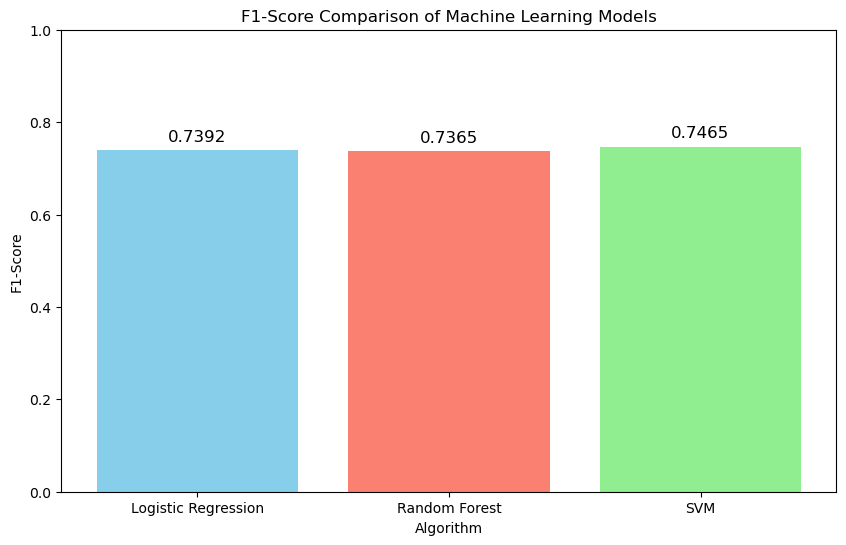

In [45]:
# -----------------------------------------------------------------------------
# 6. Visualization of Results
# -----------------------------------------------------------------------------
print("\nStep 6: Creating a visualization of model performance...")

# Get the F1-Scores for visualization
model_names = results.index
f1_scores = results['F1-Score']

# Create the bar chart
plt.figure(figsize=(10, 6))
plt.bar(model_names, f1_scores, color=['skyblue', 'salmon', 'lightgreen'])
plt.title('F1-Score Comparison of Machine Learning Models')
plt.xlabel('Algorithm')
plt.ylabel('F1-Score')
plt.ylim(0, 1)  # Set the y-axis limit for better comparison

# Add the F1-Score values on top of the bars
for i, score in enumerate(f1_scores):
    plt.text(i, score + 0.02, f'{score:.4f}', ha='center', fontsize=12)

plt.show()
